# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/competitions/tweet-sentiment-extraction')
df = pd.read_csv('tweet-sentiment-extraction/train.csv')

print(df.head())

print(df.dtypes)

print("\nКількість записів та пропущених значень:")
print(df.info())
print("\nКількість пропущених значень у кожному стовпчику:")
print(df.isnull().sum())

df = df.dropna()

print("\nРозмірність даних після видалення пропущених значень:")
print(df.shape)

Extracting archive ./tweet-sentiment-extraction/tweet-sentiment-extraction.zip to ./tweet-sentiment-extraction
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  
textID           object
text             object
selected_text    object
sentiment        object
dtype: object

Кількість записів та пропущених значень:
<class 'pandas.core.fr

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


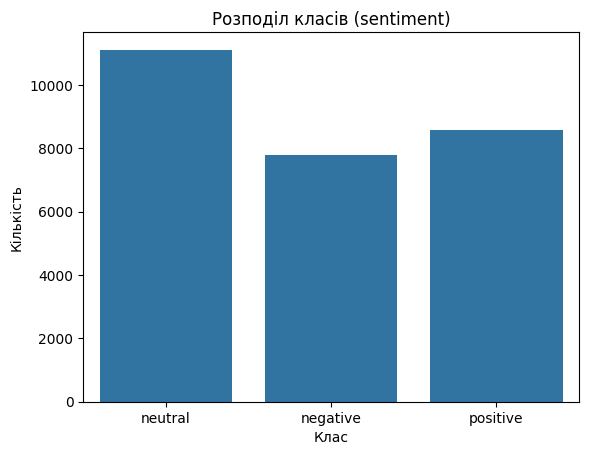

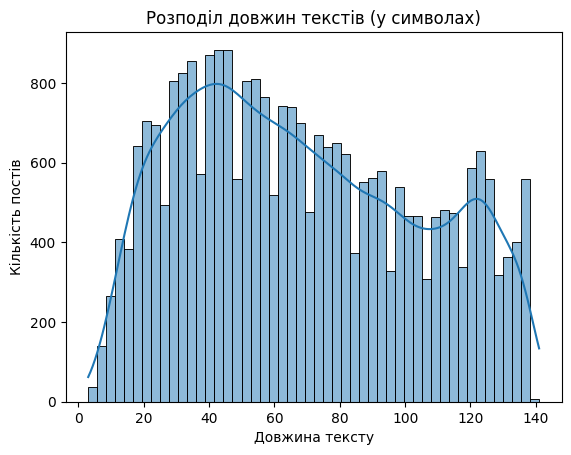

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sns.countplot(x='sentiment', data=df)
plt.title('Розподіл класів (sentiment)')
plt.xlabel('Клас')
plt.ylabel('Кількість')
plt.show()

text_lengths = df['text'].apply(len)
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Розподіл довжин текстів (у символах)')
plt.xlabel('Довжина тексту')
plt.ylabel('Кількість постів')
plt.show()


**Висновки**

Найбільше постів мають довжину від 30 до 60 символів. Це очікувано для Twitter.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


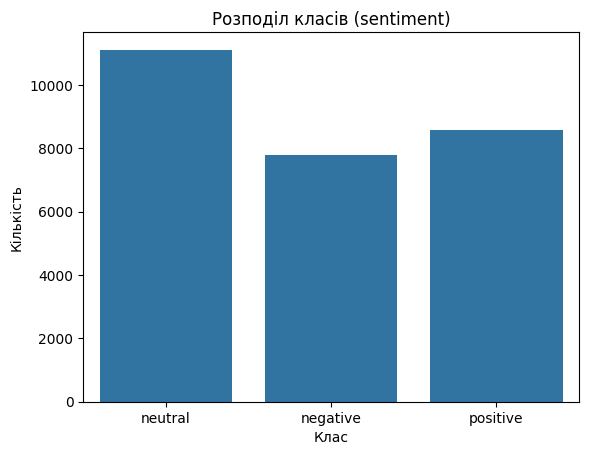

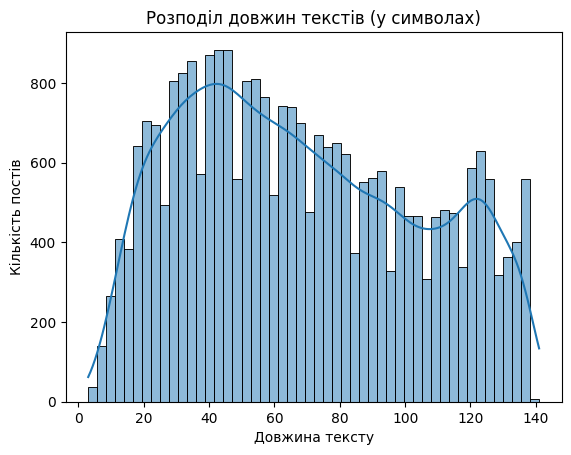

(27480, 1000)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sns.countplot(x='sentiment', data=df)
plt.title('Розподіл класів (sentiment)')
plt.xlabel('Клас')
plt.ylabel('Кількість')
plt.show()

text_lengths = df['text'].apply(len)
sns.histplot(text_lengths, bins=50, kde=True)
plt.title('Розподіл довжин текстів (у символах)')
plt.xlabel('Довжина тексту')
plt.ylabel('Кількість постів')
plt.show()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stems = [stemmer.stem(word) for word in tokens]
    return ' '.join(stems)

df['processed_text'] = df['text'].apply(preprocess_text)

vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(df['processed_text'])
print(X_bow.shape)


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stems = [stemmer.stem(word) for word in tokens]
    return ' '.join(stems)

df['processed_text'] = df['text'].apply(preprocess_text)

vectorizer = CountVectorizer(max_features=1000)
X_bow = vectorizer.fit_transform(df['processed_text'])
y = df['sentiment']

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train_bow, y_train)
    y_pred = model.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.6894
              precision    recall  f1-score   support

    negative       0.72      0.58      0.64      1572
     neutral       0.63      0.75      0.68      2236
    positive       0.76      0.72      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496


Decision Tree Accuracy: 0.6215
              precision    recall  f1-score   support

    negative       0.58      0.62      0.60      1572
     neutral       0.61      0.59      0.60      2236
    positive       0.68      0.67      0.68      1688

    accuracy                           0.62      5496
   macro avg       0.62      0.63      0.62      5496
weighted avg       0.62      0.62      0.62      5496


Gradient Boosting Accuracy: 0.6572
              precision    recall  f1-score   support

    negative       0.77      0.42      0.55      1572
     neutral       0.57

**Висновки**

Logistic Regression: 0.6894 — найкращий результат серед трьох моделей.

Gradient Boosting: 0.6570 — трохи гірше.

Decision Tree: 0.6225 — найгірший результат, схильна до переобучення.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


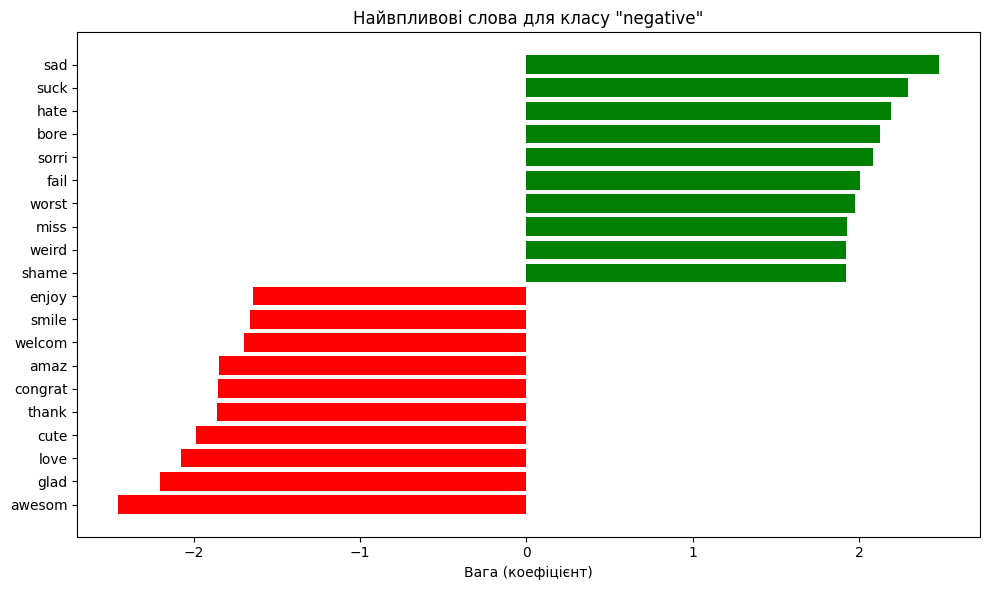

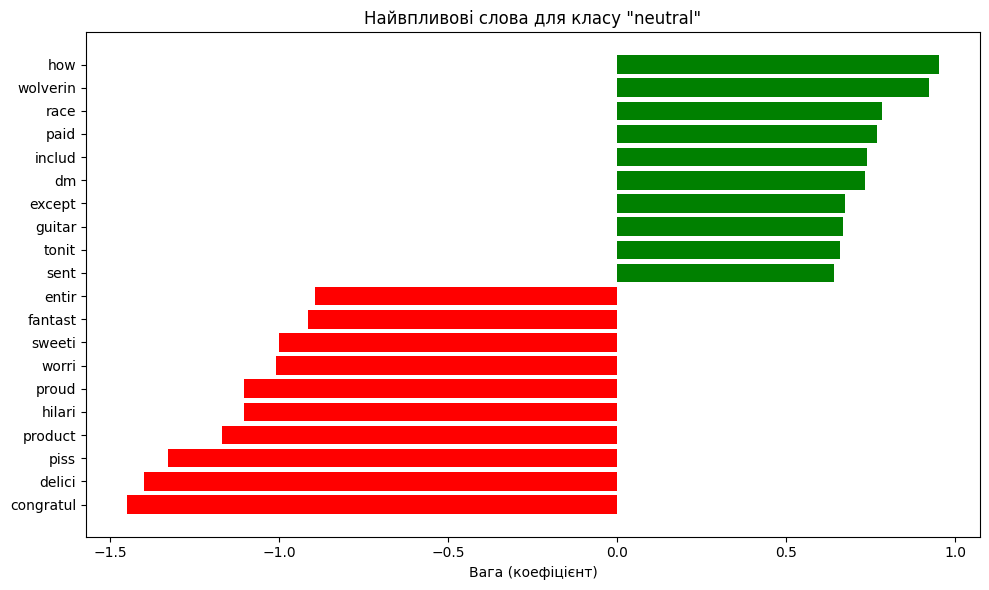

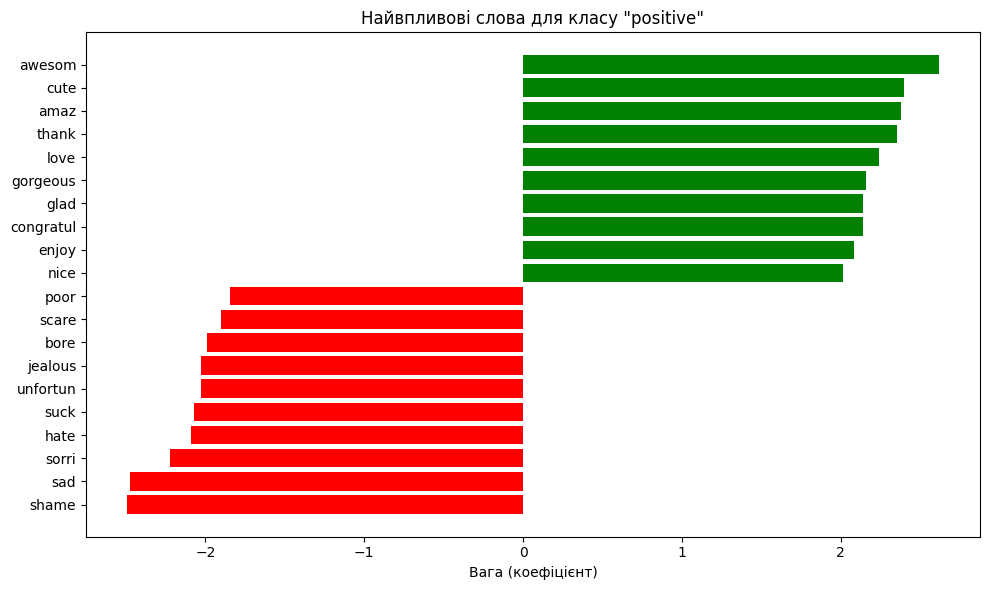

In [8]:
import numpy as np
logreg = models["Logistic Regression"]

classes = logreg.classes_
coefs = logreg.coef_
feature_names = vectorizer.get_feature_names_out()

def plot_most_influential_words(class_index, class_label, top_n=10):
    top_pos = np.argsort(coefs[class_index])[-top_n:]
    top_neg = np.argsort(coefs[class_index])[:top_n]
    top_indices = np.concatenate([top_neg, top_pos])

    words = feature_names[top_indices]
    weights = coefs[class_index][top_indices]
    colors = ['red'] * top_n + ['green'] * top_n

    plt.figure(figsize=(10, 6))
    plt.barh(words, weights, color=colors)
    plt.title(f'Найвпливові слова для класу \"{class_label}\"')
    plt.xlabel('Вага (коефіцієнт)')
    plt.tight_layout()
    plt.show()

for i, class_label in enumerate(classes):
    plot_most_influential_words(i, class_label)


**Висновки**

Графіки показують досить логічні результати.
Бачимо  явну різницу у политивних і негативних словах.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('punkt')

df = pd.read_csv('tweet-sentiment-extraction/train.csv')
df = df.dropna()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stems = [stemmer.stem(word) for word in tokens]
    return ' '.join(stems)

df['processed_text'] = df['text'].apply(preprocess_text)

vectorizer_tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer_tfidf.fit_transform(df['processed_text'])
y = df['sentiment']

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

logreg_tfidf = LogisticRegression(max_iter=1000)
logreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"\nLogistic Regression (TF-IDF) Accuracy: {acc_tfidf:.4f}")
print(classification_report(y_test, y_pred_tfidf))

feature_names_tfidf = vectorizer_tfidf.get_feature_names_out()
coefs_tfidf = logreg_tfidf.coef_
classes_tfidf = logreg_tfidf.classes_

for i, label in enumerate(classes_tfidf):
    top_positive_coefficients = np.argsort(coefs_tfidf[i])[-10:]
    top_negative_coefficients = np.argsort(coefs_tfidf[i])[:10]
    print(f"\nКлас: {label}")
    print("Найвпливовіші слова:")
    for index in reversed(top_positive_coefficients):
        print(f"  + {feature_names_tfidf[index]}: {coefs_tfidf[i][index]:.4f}")
    for index in top_negative_coefficients:
        print(f"  - {feature_names_tfidf[index]}: {coefs_tfidf[i][index]:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Logistic Regression (TF-IDF) Accuracy: 0.6869
              precision    recall  f1-score   support

    negative       0.71      0.57      0.63      1572
     neutral       0.63      0.75      0.69      2236
    positive       0.77      0.71      0.74      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.68      5496
weighted avg       0.69      0.69      0.69      5496


Клас: negative
Найвпливовіші слова:
  + sad: 4.7224
  + miss: 4.2853
  + suck: 4.0304
  + hate: 3.9176
  + sorri: 3.7816
  + bore: 3.3935
  + fail: 3.2410
  + hurt: 3.1801
  + sick: 3.0707
  + tire: 3.0090
  - love: -4.5023
  - awesom: -3.6148
  - thank: -3.5977
  - hope: -2.8750
  - glad: -2.7488
  - great: -2.5400
  - cute: -2.4019
  - nice: -2.3115
  - enjoy: -2.2530
  - amaz: -2.2269

Клас: neutral
Найвпливовіші слова:
  + how: 1.1525
  + wolverin: 0.8880
  + dm: 0.8270
  + goin: 0.7845
  + includ: 0.7760
  + race: 0.7698
  + sent: 0.7621
  + paid: 0.7431
  + g

**Висновки**

У результатах видно слова (по спаданню важливості), які впливають на результат.

- Збіг у топових токенах для обох методів: у результатах обох методів є однакові слова, такі як sad, suck, hate, love, thank, awesome.

- Відмінності: TF-IDF сильніше підкреслює емоційно насичені слова (happi, miss, fail, hope, great) тоді як BoW має трохи більше випадкових слів (наприклад, sweeti, fantast).

Accuracy обох методів майже співпадаюсь, але я б обрала все одно TF-IDF, він якось краше розуміє відтінки слів.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [14]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df['sentiment'] = y.values
X_tfidf_df['text'] = df['text'].values

X_train, X_test, y_train, y_test, text_train, text_test = train_test_split(
    X_tfidf_df.drop(columns=['sentiment', 'text']),
    X_tfidf_df['sentiment'],
    X_tfidf_df['text'],
    test_size=0.2,
    random_state=42
)

logreg_tfidf = LogisticRegression(max_iter=1000)
logreg_tfidf.fit(X_train, y_train)
y_pred_tfidf = logreg_tfidf.predict(X_test)

errors_mask = y_test != y_pred_tfidf
wrong_samples = pd.DataFrame({
    'text': text_test[errors_mask],
    'true': y_test[errors_mask],
    'predicted': y_pred_tfidf[errors_mask]
})

print(wrong_samples.head(10))


                                                    text      true predicted
10413   --of them kinda turns me off of it all.  And ...  negative   neutral
579     OHSHNAPSSS. is she pissed at blair as usual ?...   neutral  negative
6717                     At work... What a miserable day  negative   neutral
2830                                I wish I had company  negative   neutral
16792  Intel gfx driver situation much better with re...  negative  positive
4890                 xD  hello that`s an important date!  positive   neutral
14498       its my birthday.....happy birthday to me!!!!  positive   neutral
17381  FYI no internets until THURSTAG!!!! after satu...  positive  negative
12311  i totally need to go to the doctor for my arm....  negative   neutral
10108   I think that`s cutting off the URL so the pic...   neutral  negative


**Висновки**

По прикладам вище видно, що модель помиляється якщо немає явних емоційний слів, типу sad або love. Тому помилково позначає данні.

Як покращити:

- попередньо очистити данні від знаків та смайликів, як от xD. Все ж таки це шум.
- Або/та додати розпізнавання смайликів. Хоча це не взятує нас від сарказму.
- можливо, збалансувати класи, бо негативного класу у нас в даних менше.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model